In [1]:
import math
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import KMeans

import requests

In [2]:
breeds = requests.request('GET', 'https://api.thecatapi.com/v1/breeds').json()
breed0 = breeds[0]
numeric_features = []
for key, value in breed0.items():
    if isinstance(value, (int, float)):
        numeric_features.append(key)

numeric_features.remove('lap') # crutch to fix keyerror, inconsistent api object

colnames =['id'] + numeric_features
df = pd.DataFrame(columns=colnames)
for breed in breeds:
    row = {key: breed[key] for key in colnames}

    df = df.append(row, ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 67 non-null     object
 1   indoor             67 non-null     object
 2   adaptability       67 non-null     object
 3   affection_level    67 non-null     object
 4   child_friendly     67 non-null     object
 5   dog_friendly       67 non-null     object
 6   energy_level       67 non-null     object
 7   grooming           67 non-null     object
 8   health_issues      67 non-null     object
 9   intelligence       67 non-null     object
 10  shedding_level     67 non-null     object
 11  social_needs       67 non-null     object
 12  stranger_friendly  67 non-null     object
 13  vocalisation       67 non-null     object
 14  experimental       67 non-null     object
 15  hairless           67 non-null     object
 16  natural            67 non-null     object
 17 

/tmp/ipykernel_9135/820041203.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/tmp/ipykernel_9135/820041203.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/tmp/ipykernel_9135/820041203.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/tmp/ipykernel_9135/820041203.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
/tmp/ipykernel_9135/820041203.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

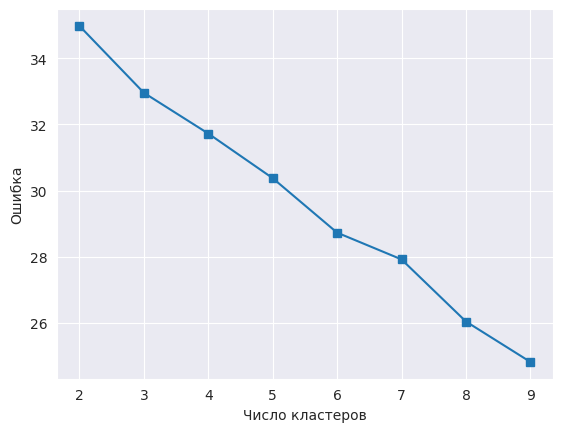

In [3]:
pd.options.mode.chained_assignment = None
df.dropna()
noid = df.drop(columns=('id'))

scaler = StandardScaler()
scaled = scaler.fit_transform(noid)

inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=1337).fit(scaled)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(2, 10), inertia, marker='s');
plt.xlabel('Число кластеров')
plt.ylabel('Ошибка');


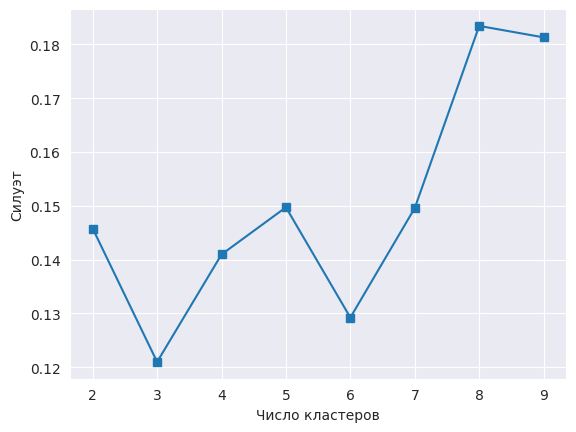

In [4]:
sil = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=1337).fit(scaled)
    sil.append(metrics.silhouette_score(scaled, kmeans.labels_))

plt.plot(range(2, 10), sil, marker='s');
plt.xlabel('Число кластеров')
plt.ylabel('Силуэт');


In [59]:
kmodel = KMeans(n_clusters=4, random_state=1337)
kmodel.fit(scaled)
df["cluster"] = kmodel.labels_
df.groupby("cluster").mean()


/tmp/ipykernel_23138/309217567.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("cluster").mean()


,indoor,adaptability,affection_level,child_friendly,dog_friendly,energy_level,grooming,health_issues,intelligence,shedding_level,...,stranger_friendly,vocalisation,experimental,hairless,natural,rare,rex,suppressed_tail,short_legs,hypoallergenic
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.125,3.875000,4.250000,2.750000,2.750000,2.875000,2.750000,2.250000,3.250000,2.875000,...,2.500000,2.125000,0.000000,0.125000,0.500000,0.125000,0.000000,0.0,0.000000,0.125000
1,0.000,5.000000,5.000000,4.166667,5.000000,4.500000,1.333333,1.833333,5.000000,3.500000,...,3.833333,3.000000,0.000000,0.000000,0.500000,0.000000,0.000000,1.0,0.000000,0.000000
2,0.000,4.947368,4.921053,3.947368,4.842105,3.868421,2.026316,1.736842,4.315789,2.684211,...,3.815789,2.684211,0.078947,0.026316,0.236842,0.052632,0.000000,0.0,0.052632,0.000000
3,0.000,4.933333,5.000000,4.000000,4.866667,4.333333,1.333333,2.733333,4.800000,2.333333,...,4.133333,3.466667,0.000000,0.066667,0.066667,0.066667,0.333333,0.0,0.000000,0.933333


In [58]:
df.cluster.value_counts()

2    38
3    15
0     8
1     6
Name: cluster, dtype: int64

In [41]:
# https://stackoverflow.com/questions/5452576/k-means-algorithm-variation-with-equal-cluster-size
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np


def get_even_clusters(X, cluster_size):
    n_clusters = int(np.ceil(len(X)/cluster_size))
    kmeans = KMeans(n_clusters)
    kmeans.fit(X)
    centers = kmeans.cluster_centers_
    centers = centers.reshape(-1, 1, X.shape[-1]).repeat(cluster_size, 1).reshape(-1, X.shape[-1])
    distance_matrix = cdist(X, centers)
    clusters = linear_sum_assignment(distance_matrix)[1]//cluster_size
    return clusters

clusters = get_even_clusters(X=scaled, cluster_size=14)


In [43]:
all_handles = []
n_clusters = np.unique(clusters)
for _ in n_clusters:
    all_handles.append([])

for breed_index, cluster_id in enumerate(clusters):
    breed_id = df.iloc[breed_index]['id']
    all_handles[cluster_id].append(breed_id)

for handle in all_handles:
    print(handle)

['abob', 'ctif', 'cymr', 'hbro', 'jbob', 'kuri', 'manx', 'norw', 'pixi', 'sing', 'tonk', 'toyg', 'tang', 'tvan']
['abys', 'awir', 'bamb', 'chau', 'dons', 'kora', 'munc', 'nebe', 'sava', 'srex', 'sphy']
['acur', 'amau', 'amis', 'birm', 'bslo', 'cspa', 'chee', 'cypr', 'mcoo', 'mala', 'raga', 'ragd', 'snow', 'ycho']
['aege', 'asho', 'bsho', 'buri', 'csho', 'lihu', 'emau', 'esho', 'hima', 'khao', 'pers', 'rblu', 'sfol', 'soma']
['bali', 'beng', 'bomb', 'bure', 'char', 'crex', 'drex', 'ebur', 'java', 'lape', 'ocic', 'orie', 'siam', 'sibe']
